In [36]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Grouper
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

First start taking a look at the dataset itself

In [37]:
#Opening the dataset and setting date as index
df = pd.read_csv("Electric_Production.csv")
df = df.set_index("DATE")
df.index = pd.to_datetime(df.index, format='%d-%m-%Y')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


,Value
DATE,
1985-01-01,72.5052
1985-01-02,70.6720
1985-01-03,62.4502
1985-01-04,57.4714
1985-01-05,55.3151


<AxesSubplot:xlabel='DATE'>

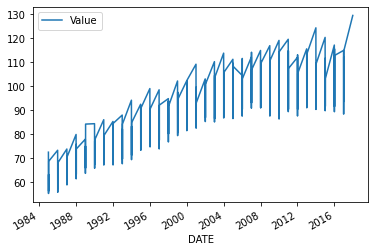

In [38]:
df.plot(y='Value')

First we split our data set into a training and a test series.
In our case, we use the complete first 27 years as training and the last 6 years as test. This is a roughly 80-20 split keeping complete years intact. 

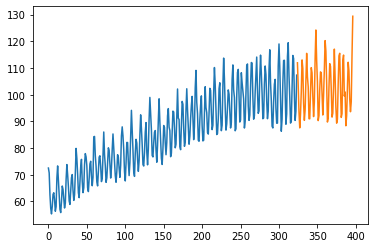

In [39]:
def train_test_split(timeseries):
    TRAIN_SIZE = 12 * 27
    TEST_SIZE = len(timeseries) - TRAIN_SIZE

    # Splitting the last 2 years for test
    train = timeseries[:TRAIN_SIZE].values
    plt.plot(np.arange(TRAIN_SIZE), train)
    train = train.reshape((TRAIN_SIZE, 1))

    test = timeseries[TRAIN_SIZE:].values
    plt.plot(np.arange(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE), test)
    test = test.reshape((TEST_SIZE, 1))

    return train, test


train, test = train_test_split(df["Value"])

# First method: prediction using SARIMA

We check for seasonality by plotting some years simulteanously and seeing if the ups and downs agree over the months.

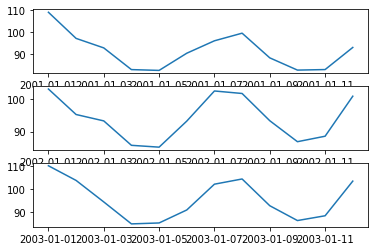

In [40]:
groups = df["Value"]['2001':'2003'].groupby(Grouper(freq='A'))
i = 1
n = len(groups)
for name, group in groups:
    plt.subplot((n * 100) + 10 + i)
    i += 1
    plt.plot(group)

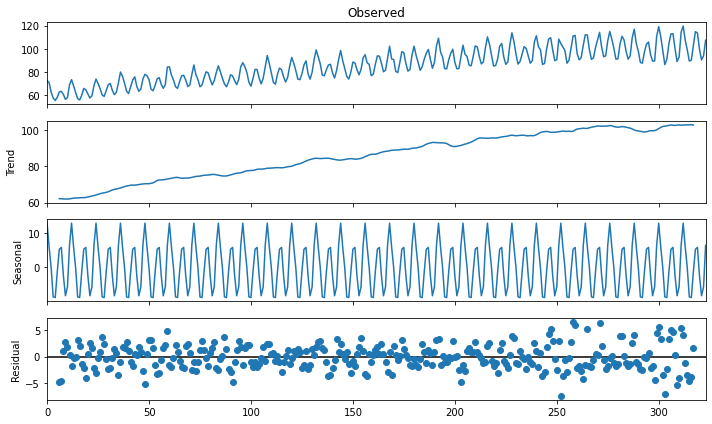

In [41]:
#since the seasonality observerd above was 1 year and our data is monthly, we have a period of 12
decomposed = seasonal_decompose(train, model="additive", period=12)

fig = decomposed.plot()
fig.set_size_inches((10, 6))
fig.tight_layout()
plt.show()

Next we test for stationarity. For this we use the FullerTest.

In [42]:
def adfuller_test(data):
    result = adfuller(data)
    labels = ['ADF Statistic', 'p-value', '#lags used', 'Number of Observations Used']
    for value, labels in zip(result, labels):
        print(f"{labels}: {value}")
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is NOT stationary")


adfuller_test(train)

ADF Statistic: -1.9502731138118903
p-value: 0.3087928413929083
#lags used: 15
Number of Observations Used: 308
Data is NOT stationary


In [43]:
train_diffs = train[:-12] - train[12:]
adfuller_test(train_diffs)

ADF Statistic: -5.7671094010141415
p-value: 5.50003394164732e-07
#lags used: 12
Number of Observations Used: 299
Data is stationary


In [44]:
training_window = len(train)
history = [x for x in train]
history = history[(-training_window):] 

predictions = []

# the p,d,q are here determined manually, but can also be set via systematic search over the parameter space
order = (2, 0, 2)
seasonal_order = (0, 1, 1, 12)

for i in range(len(test)):
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
    # predict 
    model_fit = model.fit(disp=0)
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    obs = test[i]
    history.append(obs)
    history.pop(0)
    
# report performance
rmse = math.sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 3.224


In [45]:
def forecast(model,predict_steps):
    
    pred_uc = model.get_forecast(steps=predict_steps, dynamic=True)

    #SARIMAXResults.conf_int,the default alpha = .05 returns a 95% confidence interval.
    pred_mean = pred_uc.predicted_mean
    pred_ci = pred_uc.conf_int()
    
    index = pd.date_range('2018-02-01', '2020-1-01', freq='MS') 
    prediction_table = pd.DataFrame({'Predicted_Mean':pred_mean,
                                     'Lower Bound':pred_ci[:,0],
                                     'Upper Bound':pred_ci[:,1]},
                                   index=index)
    return prediction_table

# we want to predict the next 2 years
predictions = forecast(model_fit, 24)
predictions

,Predicted_Mean,Lower Bound,Upper Bound
2018-02-01,120.492098,115.617328,125.366867
2018-03-01,108.838876,103.158252,114.519501
2018-04-01,101.550534,95.709251,107.391818
2018-05-01,90.414454,84.518068,96.310841
2018-06-01,92.412391,86.485039,98.339743
2018-07-01,103.264962,97.313643,109.216281
2018-08-01,112.655459,106.682528,118.628390
2018-09-01,111.627116,105.633457,117.620774
2018-10-01,100.982056,94.968055,106.996056
2018-11-01,92.908603,86.874469,98.942737


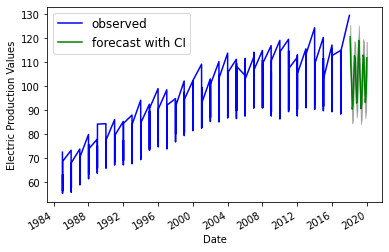

In [46]:
plt.plot(df['Value'], color = "blue", label='observed')
predictions['Predicted_Mean'].plot(color = "green", label='forecast with CI')
plt.fill_between(predictions.index, predictions['Lower Bound'], predictions['Upper Bound'], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Electric Production Values')
plt.legend(loc='upper left', fontsize=12)
plt.show()

# Second method: prediction using a simple RNN 

To compare to stastical methods, we implement here a simple RNN using just 10 units.
We are here using an already defined model from the keras framework. 


In [47]:
length = 12
generator = TimeseriesGenerator(train, train, length=length, batch_size=1)
validation_generator = TimeseriesGenerator(test, test, length=length, batch_size=1)

In [48]:
def create_model(num_hidden_units=10):
    model = Sequential()
    model.add(SimpleRNN(num_hidden_units, activation='relu', input_shape=(length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


model = create_model(10)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [49]:
def train_model(model, savefile, verbose=1):
    epochs = 100
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    ckpt = ModelCheckpoint(savefile, save_best_only=True, monitor='val_loss', verbose=verbose)
    history = model.fit_generator(
        generator,
        steps_per_epoch=len(generator),
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[early_stop, ckpt],
        verbose=verbose)

    return history


history_for_10_units = train_model(model, "best_rnn_10.hdf5")

Epoch 1/100


<ipython-input-49-ff78d7734b75>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


299/312 [===========================>..] - ETA: 0s - loss: 392.6122
Epoch 1: val_loss improved from inf to 153.38983, saving model to best_rnn_10.hdf5
312/312 [==============================] - 2s 4ms/step - loss: 379.3759 - val_loss: 153.3898
Epoch 2/100
305/312 [============================>.] - ETA: 0s - loss: 82.5793
Epoch 2: val_loss improved from 153.38983 to 129.07347, saving model to best_rnn_10.hdf5
312/312 [==============================] - 1s 3ms/step - loss: 83.0305 - val_loss: 129.0735
Epoch 3/100
307/312 [============================>.] - ETA: 0s - loss: 61.0049
Epoch 3: val_loss improved from 129.07347 to 85.65765, saving model to best_rnn_10.hdf5
312/312 [==============================] - 1s 3ms/step - loss: 60.7669 - val_loss: 85.6577
Epoch 4/100
312/312 [==============================] - ETA: 0s - loss: 40.2429
Epoch 4: val_loss improved from 85.65765 to 43.92582, saving model to best_rnn_10.hdf5
312/312 [==============================] - 1s 3ms/step - loss: 40.2429 -

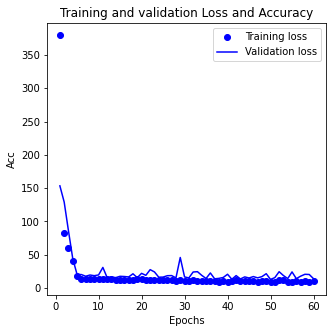

In [50]:
def plot_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs_x = range(1, len(loss_values) + 1)
    plt.figure(figsize=(5, 5))
    plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
    plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation Loss and Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()
    plt.show()


plot_loss(history_for_10_units)

In [51]:
def evaluate_model(savefile):
    model.load_weights(savefile)

    # Predicting some days ahead.
    test_predictions = []
    first_eval_batch = train[-length:]
    current_batch = first_eval_batch.reshape((1, length, 1))
    for i in range(len(test)):
        current_pred = model.predict(current_batch)[0]

        test_predictions.append(current_pred)

        #add out current prediction to the input
        current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

    # compute the mean square root error between test and test_predictions
    loss = np.mean(np.square(test[:, 0] - np.array(test_predictions)[:, 0]), axis=-1)
    return loss, test_predictions


loss, test_predictions = evaluate_model("best_rnn_10.hdf5")
print(f"mse: {loss}")

1/1 [==============================] - 0s 16ms/step
mse: 89.22225334465618


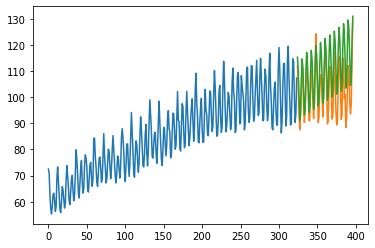

In [52]:
# Comparing test data and predictions
plt.plot(np.arange(len(train)), train)
plt.plot(np.arange(len(train), len(train) + len(test)), test)
plt.plot(np.arange(len(train), len(train) + len(test)), test_predictions)

Try varying the number of units in the RNN. Does this improve the prediction accuracy?

In [ ]:
loss_per_num_units = []
for num_units in range(5, 31, 5):
    model = create_model(num_units)
    history_for_10_units = train_model(model, f"best_rnn_{num_units}.hdf5", verbose=0)
    loss, test_predictions = evaluate_model(f"best_rnn_{num_units}.hdf5")
    loss_per_num_units.append(loss)

<ipython-input-49-ff78d7734b75>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1/1 [==============================] - 0s 15ms/step


In [ ]:
print(loss_per_num_units)
plt.plot(np.arange(5, 31, 5), loss_per_num_units)